[View in Colaboratory](https://colab.research.google.com/github/larraindie/precio_bitcoins/blob/master/bitcoin.ipynb)

In [0]:
import keras
keras.__version__

'2.1.6'

#Predicción de cotización del bitcoin utilizando redes recurrentes

 

Para comenzar, importamos algunas librerías necesarias para importar los valores históricos del bitcoin.

Partimos  de un baseline de rmse = 61.74 correspondiente a tomar el precio del bitcoin del día actual como válido para el día de mañana.

In [0]:
import os
import numpy as np
import pandas as pd


from google.colab import files
#files.upload()

dfbit2 = pd.read_csv("bitcoin_price.csv", parse_dates=['Date'])

f = open("bitcoin_price.csv")
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:] 

print(header)
print(len(lines))
print(lines)


['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
1656
['Apr 28 2013,135.30,135.98,132.10,134.21,-,1500520000', 'Apr 29 2013,134.44,147.49,134.00,144.54,-,1491160000', 'Apr 30 2013,144.00,146.93,134.05,139.00,-,1597780000', 'May 01 2013,139.00,139.89,107.72,116.99,-,1542820000', 'May 02 2013,116.38,125.60,92.28,105.21,-,1292190000', 'May 03 2013,106.25,108.13,79.10,97.75,-,1180070000', 'May 04 2013,98.10,115.00,92.50,112.50,-,1089890000', 'May 05 2013,112.90,118.80,107.14,115.91,-,1254760000', 'May 06 2013,115.98,124.66,106.64,112.30,-,1289470000', 'May 07 2013,112.25,113.44,97.70,111.50,-,1248470000', 'May 08 2013,109.60,115.78,109.60,113.57,-,1219450000', 'May 09 2013,113.20,113.46,109.26,112.67,-,1259980000', 'May 10 2013,112.80,122.00,111.55,117.20,-,1255970000', 'May 11 2013,117.70,118.68,113.01,115.24,-,1311050000', 'May 12 2013,115.64,117.45,113.44,115.00,-,1288630000', 'May 13 2013,114.82,118.70,114.50,117.98,-,1279980000', 'May 14 2013,117.98,119.80,110.25,111.5

Mostramos el dataframe . Vamos a trabajar con columna "Close" correspondiente al valor de cierre del Bitcoin para cada día. 

Contamos con 1655 valores históricos de cierre, correspondientes a 1655 días entre Nov 07 2017 y Apr 28 2013.

In [0]:
dfbit2.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2013-04-28,135.30,135.98,132.10,134.21,-,1500520000
1,2013-04-29,134.44,147.49,134.00,144.54,-,1491160000
2,2013-04-30,144.00,146.93,134.05,139.00,-,1597780000
3,2013-05-01,139.00,139.89,107.72,116.99,-,1542820000
4,2013-05-02,116.38,125.60,92.28,105.21,-,1292190000


Graficamos los datos en orden cronológico.

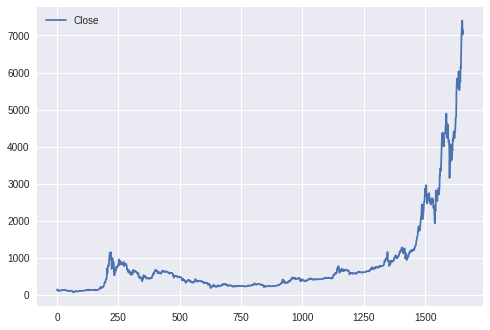

In [0]:
dfbit2.plot( y='Close')

In [0]:
float_data=dfbit2.iloc[:,4:5].values

## Preparando la data
La formulación exacta a nuestro problema será la siguiente: dados algunos puntos tan anteriores como lookback-timesteps (un timestep equivale a 1 día o 10 días) y tomando muestras cada steps timesteps, podemos predecir el valor del bitcoin en delay timesteps?

Usaremos los siguientes valores para los parámetros:

lookback = 10/1, nuestras observaciones se remiten a 10 días antes o 1 día antes.
steps = 1, nuestras observaciones serán sampleadas como un punto por día.
delay = 1, nuestros targets serán 24 horas en el futuro.

Utilizaremos el siguiente generador de Python:

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=10, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay]
        yield samples, targets

Inicializamos tres generadores principales, uno de training, uno de validación y uno de testing.

In [0]:
lookback = 10
step = 1
delay = 1
batch_size = 50

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=1000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=1001,
                    max_index=1300,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=1301,
                     max_index=None,
                     step=step,
                     batch_size=1)

predict_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=1,
                     max_index=None,
                     step=1,
                     batch_size=1)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (1600 - 1000 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 1600 - lookback) // batch_size

## Un enfoque básico de machine learning

El primer enforque que vamos aprobar es un modelo simple totalmente conectado. Comenzamos por aplanar los datos, luego lo ejecutamos a través de dos capas Dense. Probamos MAE  como la pérdida y MSE como métrica. Dado que estamos evaluando exactamente los mismos datos y con la misma métrica que con nuestro enfoque de sentido común, los resultados serán directamente comparables.

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=["mse"])
history = model.fit_generator(train_gen,
                              steps_per_epoch=20,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps
                             )

Epoch 1/20
20/20 [==============================] - 1s 66ms/step - loss: 181.5727 - mean_squared_error: 63556.0153 - val_loss: 21.4557 - val_mean_squared_error: 1165.3600
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 29.5551 - mean_squared_error: 3167.4612 - val_loss: 20.4308 - val_mean_squared_error: 1055.2742
Epoch 3/20
20/20 [==============================] - 0s 13ms/step - loss: 27.6585 - mean_squared_error: 2718.5158 - val_loss: 18.9625 - val_mean_squared_error: 874.0556
Epoch 4/20
20/20 [==============================] - 0s 10ms/step - loss: 27.4147 - mean_squared_error: 2618.9235 - val_loss: 20.9511 - val_mean_squared_error: 1031.6036
Epoch 5/20
20/20 [==============================] - 0s 12ms/step - loss: 26.2034 - mean_squared_error: 2457.0496 - val_loss: 24.3530 - val_mean_squared_error: 1161.4170
Epoch 6/20
20/20 [==============================] - 0s 11ms/step - loss: 25.0682 - mean_squared_error: 2372.1315 - val_loss: 16.8873 - val_mean_squared_err

20/20 [==============================] - 0s 14ms/step - loss: 23.0152 - mean_squared_error: 2013.8363 - val_loss: 20.5776 - val_mean_squared_error: 877.3974
Epoch 16/20
20/20 [==============================] - 0s 16ms/step - loss: 21.6394 - mean_squared_error: 1700.1906 - val_loss: 15.6548 - val_mean_squared_error: 643.5574
Epoch 17/20
20/20 [==============================] - 0s 16ms/step - loss: 22.4032 - mean_squared_error: 1814.0777 - val_loss: 16.4678 - val_mean_squared_error: 663.8241
Epoch 18/20
20/20 [==============================] - 0s 15ms/step - loss: 21.8095 - mean_squared_error: 1779.7243 - val_loss: 15.2577 - val_mean_squared_error: 628.7249
Epoch 19/20
20/20 [==============================] - 0s 14ms/step - loss: 22.2635 - mean_squared_error: 1948.2732 - val_loss: 25.7126 - val_mean_squared_error: 1106.9674
Epoch 20/20
20/20 [==============================] - 0s 15ms/step - loss: 21.8346 - mean_squared_error: 1855.9569 - val_loss: 18.0833 - val_mean_squared_error: 750.59

Veamos las curvas de pérdida en validación y entrenamiento:

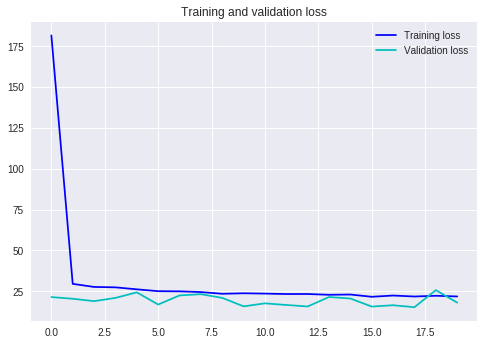

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

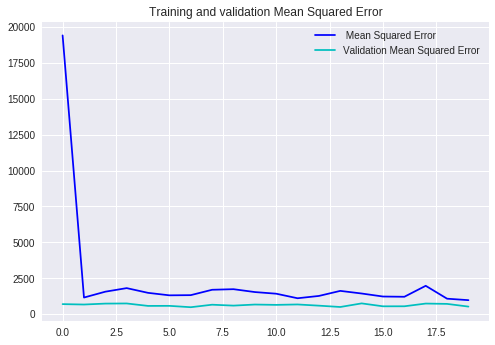

In [0]:
mean_squared_error = history.history['mean_squared_error']
val_mean_squared_error = history.history['val_mean_squared_error']

plt.plot(epochs, mean_squared_error, 'b', label=' Mean Squared Error')
plt.plot(epochs, val_mean_squared_error, 'c', label='Validation Mean Squared Error')
plt.title('Training and validation Mean Squared Error')
plt.legend()

plt.show()

In [0]:
dfbit2.iloc[:,4:5].head(10)


,Close
0,134.21
1,144.54
2,139.00
3,116.99
4,105.21
5,97.75
6,112.50
7,115.91
8,112.30
9,111.50


In [0]:
#Utilizamos el modelo para predecir los valores de test.
np.set_printoptions(threshold=np.inf)
prediccion = model.predict_generator(test_gen, steps=340, workers=1, use_multiprocessing=False, verbose=1)
prediccion

340/340 [==============================] - 1s 2ms/step


array([[ 731.90424],
       [ 724.8506 ],
       [ 728.83075],
       [ 740.8437 ],
       [ 758.19403],
       [ 757.17676],
       [ 768.2899 ],
       [ 760.6676 ],
       [ 761.51874],
       [ 760.6562 ],
       [ 757.67365],
       [ 761.68823],
       [ 758.7359 ],
       [ 764.0139 ],
       [ 767.55646],
       [ 772.6573 ],
       [ 770.7625 ],
       [ 770.24335],
       [ 775.42615],
       [ 778.5182 ],
       [ 777.976  ],
       [ 785.47754],
       [ 787.5941 ],
       [ 812.708  ],
       [ 835.7437 ],
       [ 886.80365],
       [ 886.6696 ],
       [ 901.7432 ],
       [ 918.51337],
       [ 925.24854],
       [ 944.97174],
       [ 946.40393],
       [ 959.2102 ],
       [ 956.1835 ],
       [ 992.3648 ],
       [ 997.2793 ],
       [1016.57117],
       [1108.4529 ],
       [1014.07416],
       [ 980.9545 ],
       [ 965.59924],
       [ 907.72064],
       [ 866.4474 ],
       [ 885.7283 ],
       [ 838.5072 ],
       [ 797.23584],
       [ 831.1555 ],
       [ 811.

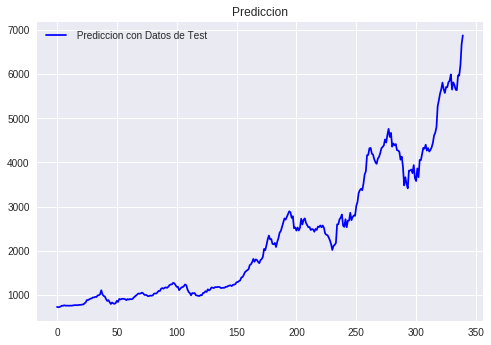

In [0]:
plt.plot(prediccion, 'b', label=' Prediccion con Datos de Test ')
plt.title('Prediccion')
plt.legend()

plt.show()

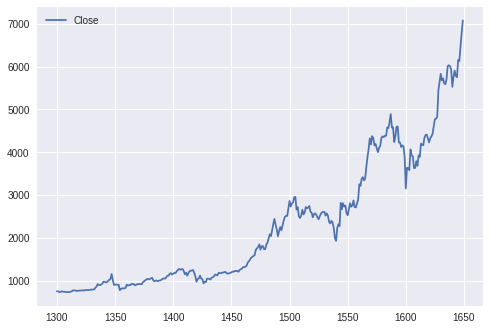

In [0]:
dfbit2.iloc[1300:1650,4:5].plot( y='Close')

Sorprendentemente este modelo simple supera el valor baseline con un MSE de 20,5 y entrenó en unos pocos segundos. Veremos si se justifica utilizar redes recurrentes.

## Modelo Recurrente Baseline

Usaremos la capa GRU, desarrollada por Cho et al. en 2014.

Las capas GRU (que significa "unidad recurrente cerrada") funcionan al aprovechar el mismo principio que LSTM, pero están algo optimizadas y, por lo tanto, son más económicas de ejecutar, aunque es posible que no tengan tanto poder de representación como LSTM.

Este trade-off entre el costo computacional y el poder de representación se ve en todas partes en el aprendizaje automático.


In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mse'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=16,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
16/16 [==============================] - 1s 68ms/step - loss: 364.3276 - mean_squared_error: 174005.1113 - val_loss: 544.9981 - val_mean_squared_error: 308127.3191
Epoch 2/10
16/16 [==============================] - 1s 32ms/step - loss: 361.5946 - mean_squared_error: 176020.1055 - val_loss: 543.6391 - val_mean_squared_error: 306508.0444
Epoch 3/10
16/16 [==============================] - 0s 31ms/step - loss: 366.0578 - mean_squared_error: 175212.0244 - val_loss: 540.5686 - val_mean_squared_error: 302705.4062
Epoch 4/10
16/16 [==============================] - 0s 30ms/step - loss: 357.8667 - mean_squared_error: 171659.5259 - val_loss: 529.9267 - val_mean_squared_error: 291977.3388
Epoch 5/10
16/16 [==============================] - 1s 32ms/step - loss: 353.1146 - mean_squared_error: 168773.0884 - val_loss: 529.9028 - val_mean_squared_error: 291851.2360
Epoch 6/10
16/16 [==============================] - 0s 30ms/step - loss: 352.7004 - mean_squared_error: 161310.7368 - val_los

Veamos los resultados:

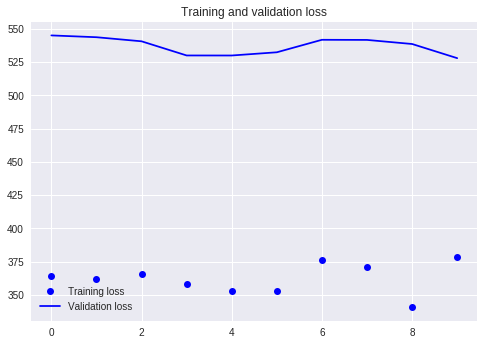

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

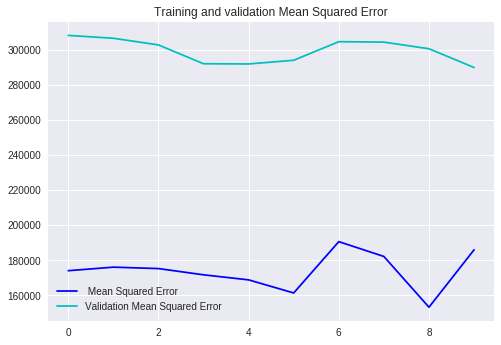

In [0]:
mean_squared_error = history.history['mean_squared_error']
val_mean_squared_error = history.history['val_mean_squared_error']

plt.plot(epochs, mean_squared_error, 'b', label=' Mean Squared Error')
plt.plot(epochs, val_mean_squared_error, 'c', label='Validation Mean Squared Error')
plt.title('Training and validation Mean Squared Error')
plt.legend()

plt.show()

Inclusive aumentando en la cantidad de neuronas, epochs y steps_per_epoch, obtenemos un resultado muy pobre. En este caso se observa un RMSE de 547,01.

## Usando recurrent dropout para  prevenir overfitting.




In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(64,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mse'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
100/100 [==============================] - 3s 34ms/step - loss: 360.6728 - mean_squared_error: 172829.9441 - val_loss: 529.8521 - val_mean_squared_error: 291564.7804
Epoch 2/20
100/100 [==============================] - 3s 26ms/step - loss: 359.5264 - mean_squared_error: 171695.1416 - val_loss: 536.3824 - val_mean_squared_error: 298810.5510
Epoch 3/20
100/100 [==============================] - 3s 26ms/step - loss: 357.0936 - mean_squared_error: 169427.7827 - val_loss: 527.6585 - val_mean_squared_error: 288773.8734
Epoch 4/20
100/100 [==============================] - 3s 26ms/step - loss: 346.2782 - mean_squared_error: 162698.9030 - val_loss: 525.8896 - val_mean_squared_error: 287381.4688
Epoch 5/20
100/100 [==============================] - 3s 26ms/step - loss: 351.2002 - mean_squared_error: 168323.1084 - val_loss: 508.8319 - val_mean_squared_error: 269964.1669
Epoch 6/20
 14/100 [===>..........................] - ETA: 2s - loss: 332.1171 - mean_squared_error: 151450.3516

100/100 [==============================] - 3s 26ms/step - loss: 334.1327 - mean_squared_error: 153810.4001 - val_loss: 505.3681 - val_mean_squared_error: 265992.1620
Epoch 7/20
100/100 [==============================] - 3s 26ms/step - loss: 329.7695 - mean_squared_error: 150393.2453 - val_loss: 509.9428 - val_mean_squared_error: 271146.1382
Epoch 8/20
100/100 [==============================] - 3s 26ms/step - loss: 326.5333 - mean_squared_error: 150691.4430 - val_loss: 501.1296 - val_mean_squared_error: 261481.2253
Epoch 9/20
100/100 [==============================] - 3s 26ms/step - loss: 319.8577 - mean_squared_error: 144904.1986 - val_loss: 497.6586 - val_mean_squared_error: 258155.1891
Epoch 10/20
100/100 [==============================] - 3s 26ms/step - loss: 308.4813 - mean_squared_error: 137402.4432 - val_loss: 481.1524 - val_mean_squared_error: 242662.6402
Epoch 11/20
 10/100 [==>...........................] - ETA: 2s - loss: 329.0555 - mean_squared_error: 154556.3258

100/100 [==============================] - 3s 26ms/step - loss: 307.0781 - mean_squared_error: 137095.7810 - val_loss: 477.4831 - val_mean_squared_error: 238811.5485
Epoch 12/20
100/100 [==============================] - 3s 26ms/step - loss: 303.0725 - mean_squared_error: 136775.6646 - val_loss: 483.7429 - val_mean_squared_error: 245111.6373
Epoch 13/20
100/100 [==============================] - 3s 25ms/step - loss: 304.4364 - mean_squared_error: 137399.2378 - val_loss: 478.8816 - val_mean_squared_error: 240293.1497
Epoch 14/20
100/100 [==============================] - 3s 26ms/step - loss: 291.3769 - mean_squared_error: 128666.0288 - val_loss: 469.6291 - val_mean_squared_error: 230901.9112
Epoch 15/20
100/100 [==============================] - 3s 26ms/step - loss: 285.1049 - mean_squared_error: 123351.3051 - val_loss: 467.8533 - val_mean_squared_error: 229708.3421
Epoch 16/20
 21/100 [=====>........................] - ETA: 1s - loss: 284.8511 - mean_squared_error: 120824.6706

100/100 [==============================] - 3s 26ms/step - loss: 274.9616 - mean_squared_error: 115617.8446 - val_loss: 450.8836 - val_mean_squared_error: 214350.2130
Epoch 17/20
100/100 [==============================] - 3s 26ms/step - loss: 272.5282 - mean_squared_error: 117354.9807 - val_loss: 448.5476 - val_mean_squared_error: 211790.1554
Epoch 18/20
100/100 [==============================] - 3s 26ms/step - loss: 271.6068 - mean_squared_error: 116549.8594 - val_loss: 453.1979 - val_mean_squared_error: 216492.8035
Epoch 19/20
100/100 [==============================] - 3s 26ms/step - loss: 270.4522 - mean_squared_error: 117941.9055 - val_loss: 444.2028 - val_mean_squared_error: 207666.4729
Epoch 20/20
100/100 [==============================] - 3s 26ms/step - loss: 262.9572 - mean_squared_error: 113171.9215 - val_loss: 440.5885 - val_mean_squared_error: 204609.3084


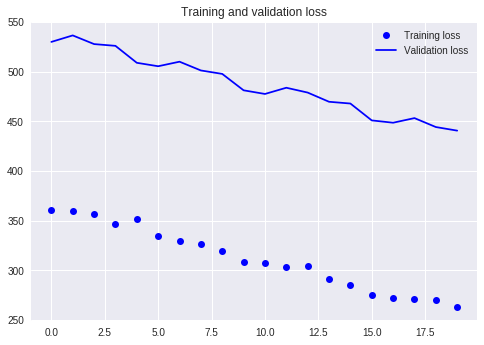

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Tras probar distintas cantidades de neuronas, epochs y steps_per_epochs logramos alcanzar un RMSE de 45,61. Mejor que el baseline pero peor que el modelo simple.

## Pila de Capas Recurrentes



In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(64,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=['mse'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
100/100 [==============================] - 6s 63ms/step - loss: 271.7655 - mean_squared_error: 121760.9418 - val_loss: 358.4771 - val_mean_squared_error: 137498.0715
Epoch 2/20
100/100 [==============================] - 5s 49ms/step - loss: 228.6264 - mean_squared_error: 91390.2470 - val_loss: 452.8432 - val_mean_squared_error: 214811.7590
Epoch 3/20
100/100 [==============================] - 5s 49ms/step - loss: 204.7596 - mean_squared_error: 75376.2993 - val_loss: 358.3214 - val_mean_squared_error: 136793.0650
Epoch 4/20
100/100 [==============================] - 5s 49ms/step - loss: 189.7201 - mean_squared_error: 70267.0313 - val_loss: 373.0988 - val_mean_squared_error: 147667.2434
Epoch 5/20
 29/100 [=======>......................] - ETA: 3s - loss: 178.1667 - mean_squared_error: 60404.3483

100/100 [==============================] - 5s 48ms/step - loss: 173.6693 - mean_squared_error: 58390.7541 - val_loss: 341.8149 - val_mean_squared_error: 125846.7545
Epoch 6/20
100/100 [==============================] - 5s 49ms/step - loss: 165.0043 - mean_squared_error: 52628.2617 - val_loss: 353.1467 - val_mean_squared_error: 132992.8890
Epoch 7/20
100/100 [==============================] - 5s 49ms/step - loss: 154.0418 - mean_squared_error: 46615.9152 - val_loss: 382.8202 - val_mean_squared_error: 153936.9490
Epoch 8/20
100/100 [==============================] - 5s 49ms/step - loss: 146.0397 - mean_squared_error: 42959.2433 - val_loss: 379.1674 - val_mean_squared_error: 151252.0699
Epoch 9/20
 38/100 [==========>...................] - ETA: 2s - loss: 143.3909 - mean_squared_error: 39729.7696

100/100 [==============================] - 5s 49ms/step - loss: 141.1989 - mean_squared_error: 40586.2154 - val_loss: 276.7767 - val_mean_squared_error: 83940.5806
Epoch 10/20
100/100 [==============================] - 5s 48ms/step - loss: 134.4897 - mean_squared_error: 37453.1009 - val_loss: 302.6778 - val_mean_squared_error: 98673.1051
Epoch 11/20
100/100 [==============================] - 5s 49ms/step - loss: 126.9492 - mean_squared_error: 32561.5645 - val_loss: 270.0336 - val_mean_squared_error: 78827.3925
Epoch 12/20
100/100 [==============================] - 5s 49ms/step - loss: 121.0210 - mean_squared_error: 31194.9889 - val_loss: 353.2917 - val_mean_squared_error: 130914.3947
Epoch 13/20
 40/100 [===========>..................] - ETA: 2s - loss: 119.0076 - mean_squared_error: 28241.9153

100/100 [==============================] - 5s 49ms/step - loss: 114.1691 - mean_squared_error: 26748.7475 - val_loss: 323.7882 - val_mean_squared_error: 110847.8343
Epoch 14/20
100/100 [==============================] - 5s 49ms/step - loss: 109.4016 - mean_squared_error: 26131.9753 - val_loss: 222.8292 - val_mean_squared_error: 56315.4445
Epoch 15/20
100/100 [==============================] - 5s 50ms/step - loss: 107.0580 - mean_squared_error: 23440.3125 - val_loss: 239.8013 - val_mean_squared_error: 62513.3185
Epoch 16/20
100/100 [==============================] - 5s 50ms/step - loss: 101.5798 - mean_squared_error: 22897.7927 - val_loss: 260.4035 - val_mean_squared_error: 72736.6098
Epoch 17/20
 33/100 [========>.....................] - ETA: 3s - loss: 101.2057 - mean_squared_error: 22674.8170

100/100 [==============================] - 5s 50ms/step - loss: 99.4591 - mean_squared_error: 21241.8209 - val_loss: 287.0793 - val_mean_squared_error: 86038.5629
Epoch 18/20
100/100 [==============================] - 5s 50ms/step - loss: 93.9726 - mean_squared_error: 19832.3166 - val_loss: 210.7650 - val_mean_squared_error: 49027.0285
Epoch 19/20
100/100 [==============================] - 5s 49ms/step - loss: 94.6824 - mean_squared_error: 20368.0057 - val_loss: 181.1972 - val_mean_squared_error: 36625.4183
Epoch 20/20
100/100 [==============================] - 5s 49ms/step - loss: 89.1442 - mean_squared_error: 18054.8831 - val_loss: 232.6020 - val_mean_squared_error: 58678.9408


Vamos los resultados:

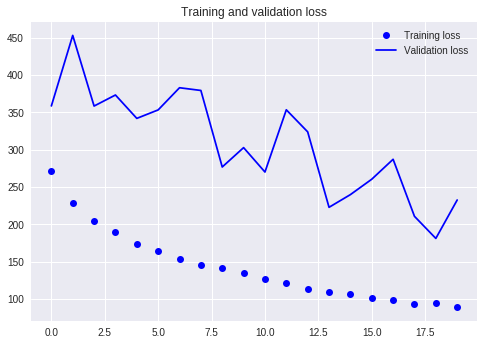

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Concluyendo



Sorprendentemente podemos concluir que de los modelos probados el más simple es el mejor y hasta lo que pudimos comprobar no se justifican los modelos de capas recurrentes.

